In [666]:
import tensorflow as tf
from tensorflow import keras
import sklearn
import numpy as np
import pandas as pd
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report
import ipaddress
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import VotingClassifier

In [430]:
def to_int(x):
    return int(x, 16)

In [431]:
path = "./datasets/iot-network-intrusion-dataset_190919/Packets_integrated/"

In [432]:
names_list = [f for f in os.listdir(path) if f.endswith('.txt')]

In [433]:
names_list

['benign-dec.txt',
 'dos-synflooding.txt',
 'mirai-ackflooding.txt',
 'mirai-hostbruteforce-1,3,5.txt',
 'mirai-hostbruteforce-2,4.txt',
 'mirai-httpflooding.txt',
 'mirai-udpflooding.txt',
 'mitm.txt',
 'scan-hostport_1.txt',
 'scan-hostport_2.txt',
 'scan-hostport_3.txt',
 'scan-hostport_4.txt',
 'scan-hostport_5.txt',
 'scan-hostport_6.txt',
 'scan-portos.txt']

# 파일 변환 코드

In [434]:
# for txt in names_list:
#     packet = pd.read_csv(os.path.join(path, txt), sep="\n", header = None)
#     packet[packet[0].str.contains("Frame \(")] = "\f"
#     packet[0] = packet[0].str[:53]
#     packet = packet[0].str.split("  ", expand=True)
#     packet = packet[[0, 1]]
#     packet = pd.DataFrame(packet.to_string(header=None, index=False).split("\f"))
#     print("Almost Done!")
#     packet[0]=packet[0].str.lstrip()
#     packet[0] = packet[0].str.replace("\n", " ")
#     for _ in range(10):
#         packet[0] = packet[0].str.replace("  ", " ")
#     packet[0] = packet[0].str[:222]
#     packet = packet[0].str.split(" ", expand=True)
#     packet=packet.fillna("00")
#     packet = packet.drop(columns=[0, 17, 34, 51, 68, 71])
#     packet=packet.replace("","00")
#     packet.to_csv(os.path.join(path, txt).replace(".txt","_hex")+".csv")
#     print(txt,"done")
# #     packet = packet.applymap(to_int)

# Reading files

In [435]:
hex_list = [f for f in os.listdir(path) if f.endswith('hex.csv')]

In [436]:
hex_list

['benign-dec_hex.csv',
 'dos-synflooding_hex.csv',
 'mirai-ackflooding_hex.csv',
 'mirai-hostbruteforce-1,3,5_hex.csv',
 'mirai-hostbruteforce-2,4_hex.csv',
 'mirai-httpflooding_hex.csv',
 'mirai-udpflooding_hex.csv',
 'mitm_hex.csv',
 'scan-hostport_1_hex.csv',
 'scan-hostport_2_hex.csv',
 'scan-hostport_3_hex.csv',
 'scan-hostport_4_hex.csv',
 'scan-hostport_5_hex.csv',
 'scan-hostport_6_hex.csv',
 'scan-portos_hex.csv']

In [437]:
dict_names=hex_list.copy()
csv_list=hex_list.copy()
for i in range(len(hex_list)):
    dict_names[i] = hex_list[i].replace("_hex.csv","")
    csv_list[i] = hex_list[i].replace("_hex","")

In [438]:
dict_names

['benign-dec',
 'dos-synflooding',
 'mirai-ackflooding',
 'mirai-hostbruteforce-1,3,5',
 'mirai-hostbruteforce-2,4',
 'mirai-httpflooding',
 'mirai-udpflooding',
 'mitm',
 'scan-hostport_1',
 'scan-hostport_2',
 'scan-hostport_3',
 'scan-hostport_4',
 'scan-hostport_5',
 'scan-hostport_6',
 'scan-portos']

In [439]:
csv_list

['benign-dec.csv',
 'dos-synflooding.csv',
 'mirai-ackflooding.csv',
 'mirai-hostbruteforce-1,3,5.csv',
 'mirai-hostbruteforce-2,4.csv',
 'mirai-httpflooding.csv',
 'mirai-udpflooding.csv',
 'mitm.csv',
 'scan-hostport_1.csv',
 'scan-hostport_2.csv',
 'scan-hostport_3.csv',
 'scan-hostport_4.csv',
 'scan-hostport_5.csv',
 'scan-hostport_6.csv',
 'scan-portos.csv']

In [440]:
X_dict = {}
for i, packets in enumerate(hex_list):
    X_dict[dict_names[i]] = pd.read_csv(os.path.join(path, packets),index_col=0, dtype=str)
    X_dict[dict_names[i]] = X_dict[dict_names[i]].join(pd.read_csv(os.path.join(path,csv_list[i])),how="outer")

In [441]:
X_dict['mirai-hostbruteforce-1,3,5']

,1,2,3,4,5,6,7,8,9,10,...,67,69,70,No.,Time,Source,Destination,Protocol,Length,Info
0,04,32,f4,45,17,b3,88,36,6c,d7,...,ff,fb,e1,1,0.000000e+00,104.74.213.186,192.168.0.24,TCP,826,[TCP segment of a reassembled PDU]
1,04,32,f4,45,17,b3,88,36,6c,d7,...,ff,fb,e1,2,2.200000e-04,104.74.213.186,192.168.0.24,TCP,1514,[TCP segment of a reassembled PDU]
2,04,32,f4,45,17,b3,88,36,6c,d7,...,ff,fb,e1,3,5.600000e-04,104.74.213.186,192.168.0.24,TCP,1514,[TCP segment of a reassembled PDU]
3,04,32,f4,45,17,b3,88,36,6c,d7,...,ff,fb,e1,4,6.370000e-04,104.74.213.186,192.168.0.24,TCP,1514,[TCP segment of a reassembled PDU]
4,04,32,f4,45,17,b3,88,36,6c,d7,...,ff,fb,e1,5,1.378000e-03,104.74.213.186,192.168.0.24,TCP,1514,[TCP segment of a reassembled PDU]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273352,88,36,6c,d7,1c,56,04,32,f4,45,...,c9,de,65,273353,1.810277e+06,192.168.0.24,211.237.6.104,TCP,66,58485 > 443 [ACK] Seq=2510 Ack=376686 Win=52...
273353,04,32,f4,45,17,b3,88,36,6c,d7,...,00,00,00,273354,1.810277e+06,EFMNetwo_d7:1c:56,Partron_45:17:b3,ARP,42,Who has 192.168.0.24? Tell 192.168.0.1
273354,88,36,6c,d7,1c,56,04,32,f4,45,...,00,00,00,273355,1.810277e+06,Partron_45:17:b3,EFMNetwo_d7:1c:56,ARP,42,192.168.0.24 is at 04:32:f4:45:17:b3
273355,bc,1c,81,4b,ae,ba,88,36,6c,d7,...,00,00,00,273356,1.810277e+06,EFMNetwo_d7:1c:56,Sichuani_4b:ae:ba,ARP,42,Who has 192.168.0.13? Tell 192.168.0.1


In [442]:
y_dict = {}
for key, value in enumerate(X_dict):
    y_dict[value] = pd.read_csv(os.path.join(path, value)+"_attacked.csv", header=None)[0][1:].apply(int)

C:\Users\hjhhi\anaconda3\envs\python3.6.8\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (0,1,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [443]:
for i in dict_names:
    print(i, len(X_dict[i]),"    attacked", len(y_dict[i]))

benign-dec 137396     attacked 0
dos-synflooding 141709     attacked 64646
mirai-ackflooding 313462     attacked 75632
mirai-hostbruteforce-1,3,5 273357     attacked 1636
mirai-hostbruteforce-2,4 179998     attacked 961
mirai-httpflooding 248294     attacked 10464
mirai-udpflooding 1187114     attacked 949284
mitm 194184     attacked 101885
scan-hostport_1 29352     attacked 1490
scan-hostport_2 37106     attacked 2701
scan-hostport_3 13555     attacked 1730
scan-hostport_4 7801     attacked 1707
scan-hostport_5 4760     attacked 2211
scan-hostport_6 6828     attacked 2401
scan-portos 211078     attacked 12970


In [444]:
label_dict={}
for i in dict_names:
    label = np.zeros(len(X_dict[i]))
    label[y_dict[i]-1] = 1
    ###위에 -1 붙여야됨
    label_dict[i] = label

In [445]:
X_dict['benign-dec']

,1,2,3,4,5,6,7,8,9,10,...,67,69,70,No.,Time,Source,Destination,Protocol,Length,Info
0,48,4b,aa,2c,d8,f9,bc,1c,81,4b,...,d3,9b,8a,1,0.000000,192.168.0.13,192.168.0.16,TCP,1498,9020 > 49784 [ACK] Seq=5029255 Ack=1 Win=186...
1,48,4b,aa,2c,d8,f9,bc,1c,81,4b,...,d3,9b,8a,2,0.000144,192.168.0.13,192.168.0.16,TCP,140,"9020 > 49784 [PSH, ACK] Seq=5030643 Ack=1 Wi..."
2,48,4b,aa,2c,d8,f9,bc,1c,81,4b,...,d3,9b,8a,3,0.000227,192.168.0.13,192.168.0.16,TCP,1502,9020 > 49784 [ACK] Seq=5030673 Ack=1 Win=186...
3,48,4b,aa,2c,d8,f9,bc,1c,81,4b,...,d3,9b,8a,4,0.000765,192.168.0.13,192.168.0.16,TCP,1498,9020 > 49784 [ACK] Seq=5032061 Ack=1 Win=186...
4,48,4b,aa,2c,d8,f9,bc,1c,81,4b,...,d3,9b,8a,5,0.000840,192.168.0.13,192.168.0.16,TCP,1502,9020 > 49784 [ACK] Seq=5033449 Ack=1 Win=186...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137391,bc,1c,81,4b,ae,ba,48,4b,aa,2c,...,07,96,8a,137392,301.084925,192.168.0.16,192.168.0.13,TCP,114,49799 > 9020 [ACK] Seq=193 Ack=1018277 Win=5...
137392,48,4b,aa,2c,d8,f9,bc,1c,81,4b,...,d8,17,b5,137393,301.085935,192.168.0.13,192.168.0.16,TCP,434,"9020 > 49799 [PSH, ACK] Seq=1018277 Ack=193 ..."
137393,48,4b,aa,2c,d8,f9,bc,1c,81,4b,...,d8,17,b5,137394,301.086577,192.168.0.13,192.168.0.16,TCP,434,"[TCP Retransmission] 9020 > 49799 [PSH, ACK]..."
137394,bc,1c,81,4b,ae,ba,48,4b,aa,2c,...,07,96,8a,137395,301.088906,192.168.0.16,192.168.0.13,TCP,114,49799 > 9020 [ACK] Seq=193 Ack=1018597 Win=5...


In [446]:
X_reduced = {}
for i in X_dict.keys():
    X_dict[i]["SourcePort"] = (X_dict[i]["37"]+X_dict[i]["38"]).apply(to_int)
    X_dict[i]["DestinationPort"] = (X_dict[i]["39"]+X_dict[i]["40"]).apply(to_int)
    X_reduced[i] = pd.DataFrame()
    X_reduced[i]["SourcePort"] = X_dict[i]["SourcePort"]    
    X_reduced[i]["DestinationPort"] = X_dict[i]["DestinationPort"]
    X_reduced[i]["Source"] = X_dict[i]["Source"]        
    X_reduced[i]["Destination"] = X_dict[i]["Destination"]
    X_reduced[i]["Time"] = X_dict[i]["Time"]        

In [447]:
# print(X_reduced["Source"].isna().sum(),
# X_reduced[i]["SourcePort"].isna().sum(),
# X_reduced[i]["Destination"].isna().sum(),
# X_reduced[i]["DestinationPort"].isna().sum(),
# X_reduced[i]["Time"].isna().sum())

In [448]:
X_dict['mirai-udpflooding']["Protocol"].unique()

array(['TCP', 'SSLv2', 'TLSv1.2', 'DNS', 'TLSv1', 'UDP', 'ARP', 'IPv4',
       'SSDP', '0x81d9', 'SSL', 'HTTP', 'IGMPv2', '0x46d0', 'ICMP',
       '0xcd9c', 'MDNS', 'ICMPv6', 'TLSv1.3', 'GQUIC', '0x1700',
       'HTTP/XML', '0x50a4', '0x0873', '0x3a24', '0x8900', '0x1800',
       'SSLv3', 'UDT', 'IPv6', '0x0801', '0x0880', '0x0a00', '0x8820',
       '0x0840', '0x08a0', '0x2000', 'LLC', '0xd816', 'NTP', '0x0820',
       '0x38e9', '0x8604', '0xc834', '0x8800', '0x0804', '0x4b00',
       'Gryphon', '0xea84', '0x0860', '0xa280', '0xc891', '0x8810',
       '0x4200', '0x858a', '0x0870', '0x9003', '0xa300', '0x4843',
       '0x0811', '0x0802', '0x0883', '0xa491', '0xc2c6', '0x0808',
       '0x0868', '0x3754', '0x6164', 'X11', '0x4eaa', '0x1020', '0x8823',
       '0xc4ef', '0xf560', '0x1805', '0x4065', '0x0810', '0x2200',
       'WTLS+WTP+WSP', '0xe000', '0x0a10', '0xe784', '0x5825', '0x881f',
       '0x49bf', '0x4840', '0x3e27', '0x3d02', '0x0000', '0x0920',
       'BROWSER', 'NBNS', '0xc0e2'

In [449]:
X_reduced['benign-dec']

,SourcePort,DestinationPort,Source,Destination,Time
0,9020,49784,192.168.0.13,192.168.0.16,0.000000
1,9020,49784,192.168.0.13,192.168.0.16,0.000144
2,9020,49784,192.168.0.13,192.168.0.16,0.000227
3,9020,49784,192.168.0.13,192.168.0.16,0.000765
4,9020,49784,192.168.0.13,192.168.0.16,0.000840
...,...,...,...,...,...
137391,49799,9020,192.168.0.16,192.168.0.13,301.084925
137392,9020,49799,192.168.0.13,192.168.0.16,301.085935
137393,9020,49799,192.168.0.13,192.168.0.16,301.086577
137394,49799,9020,192.168.0.16,192.168.0.13,301.088906


## flooding_list에 원하는 공격을 넣어 데이터를 분류할것

In [450]:
flooding_list=['dos-synflooding','mirai-ackflooding','mirai-httpflooding','mirai-udpflooding']

In [451]:
X=pd.DataFrame([])
for i in flooding_list:
    X = X.append(X_reduced[i], ignore_index=True)

In [452]:
y=[]
for i in flooding_list:
    y.extend(label_dict[i])
y = np.array(y)

In [453]:
print(X.shape, len(y))

(1890579, 5) 1890579


In [650]:
X_flooding={}
y_flooding={}
for i in flooding_list:
    X_flooding[i] = X_reduced[i]
    y_flooding[i] = label_dict[i]

In [462]:
from sklearn.preprocessing import LabelEncoder
# encoder = LabelEncoder()
# df["Protocol"] = encoder.fit_transform(df["Protocol"])
# df["Source"] = encoder.fit_transform(df["Source"])
# df["Destination"] = encoder.fit_transform(df["Destination"])
# df["Info"] = encoder.fit_transform(df["Info"])

In [469]:
encoder = LabelEncoder()
encoder.fit(X["Source"].append(X["Destination"]))
X["Source"] = encoder.transform(X["Source"])
X["Destination"] = encoder.transform(X["Destination"])

In [656]:
X

,SourcePort,DestinationPort,Source,Destination,Time
0,2048,43774,27132,27128,0.000000
1,0,45822,27128,27132,0.000545
2,9020,44144,27132,27148,0.008112
3,9020,44144,27132,27148,0.008999
4,44144,9020,27148,27132,0.011836
...,...,...,...,...,...
1890574,43238,443,27149,16,465.053197
1890575,443,43238,16,27149,465.099985
1890576,443,43238,16,27149,465.099985
1890577,43238,443,27149,16,465.101700


In [659]:
for i in X_flooding:
    X_flooding[i]["Source"] = encoder.transform(X_flooding[i]["Source"])
    X_flooding[i]["Destination"] = encoder.transform(X_flooding[i]["Destination"])

In [660]:
X_flooding['dos-synflooding']

,SourcePort,DestinationPort,Source,Destination,Time
0,2048,43774,27132,27128,0.000000
1,0,45822,27128,27132,0.000545
2,9020,44144,27132,27148,0.008112
3,9020,44144,27132,27148,0.008999
4,44144,9020,27148,27132,0.011836
...,...,...,...,...,...
141704,5353,5353,27148,61122,783705.118361
141705,5353,5353,27148,61122,783705.119037
141706,5353,5353,27148,61122,783705.225604
141707,5353,5353,27148,61122,783705.430856


In [661]:
### flooding공격은 양성 패킷이 더 많다
print(len(y), len(y[y==0]), len(y[y==1]))

1890579 790553 1100026


In [662]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
labels = ["attacked", "benign"]

In [669]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.25)

# LogisticRegression

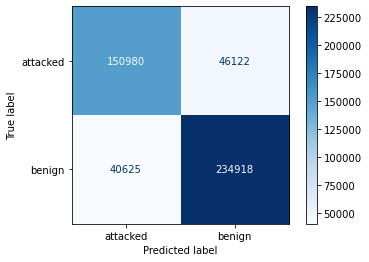

In [679]:
model = LogisticRegression(warm_start=True)
for i in X_flooding:
    X_train_classified, X_valid_classified, y_train_classified, y_valid_classified = train_test_split(X_flooding[i],y_flooding[i], test_size=0.25)
    model.fit(X_train_classified, y_train_classified)
plot = plot_confusion_matrix(model, X_valid, y_valid, display_labels=labels, cmap=plt.cm.Blues)

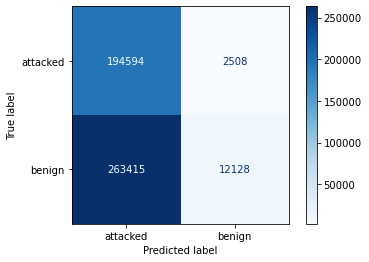

In [738]:
pred_list = []
pred_sum=[]
for i in X_flooding:
    model = LogisticRegression()
    X_train_classified, X_valid_classified, y_train_classified, y_valid_classified = train_test_split(X_flooding[i],y_flooding[i], test_size=0.25)
    model.fit(X_train_classified, y_train_classified)
    pred_list.append(model.predict(X_valid))
pred_sum = np.zeros(pred_list[0].shape)
for i in range(len(pred_list)):
    pred_sum += pred_list[i]
    
pred = pred_sum>1
cm = confusion_matrix(y_valid, pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

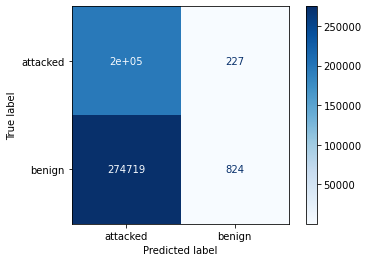

In [737]:
pred_list = []
pred_sum=[]
for i in X_flooding:
    model = LogisticRegression()
    X_train_classified, X_valid_classified, y_train_classified, y_valid_classified = train_test_split(X_flooding[i],y_flooding[i], test_size=0.25)
    model.fit(X_train_classified, y_train_classified)
    pred_list.append(model.predict_proba(X_valid))
pred_sum = np.zeros(pred_list[0].shape)
for i in range(len(pred_list)):
    pred_sum += pred_list[i]
    
pred = np.argmax(pred_sum, axis=1)
cm = confusion_matrix(y_valid, pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

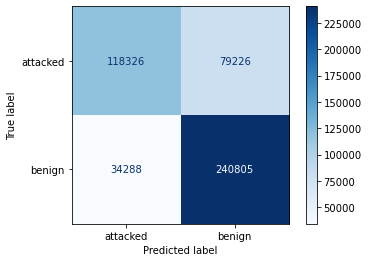

In [487]:
###max_iter
model_logistic = LogisticRegression()
model_logistic.fit(X_train, y_train)
plot = plot_confusion_matrix(model_logistic, X_valid, y_valid, display_labels=labels, cmap=plt.cm.Blues)

# KNN 

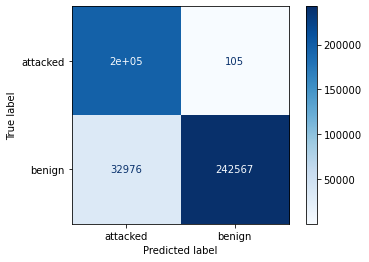

In [739]:
pred_list = []
pred_sum=[]
for i in X_flooding:
    model = KNeighborsClassifier()
    X_train_classified, X_valid_classified, y_train_classified, y_valid_classified = train_test_split(X_flooding[i],y_flooding[i], test_size=0.25)
    model.fit(X_train_classified, y_train_classified)
    pred_list.append(model.predict(X_valid))
pred_sum = np.zeros(pred_list[0].shape)
for i in range(len(pred_list)):
    pred_sum += pred_list[i]
    
pred = pred_sum>1
cm = confusion_matrix(y_valid, pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

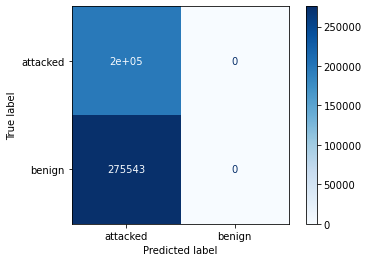

In [740]:
pred_list = []
pred_sum=[]
for i in X_flooding:
    model = KNeighborsClassifier()
    X_train_classified, X_valid_classified, y_train_classified, y_valid_classified = train_test_split(X_flooding[i],y_flooding[i], test_size=0.25)
    model.fit(X_train_classified, y_train_classified)
    pred_list.append(model.predict_proba(X_valid))
pred_sum = np.zeros(pred_list[0].shape)
for i in range(len(pred_list)):
    pred_sum += pred_list[i]
    
pred = np.argmax(pred_sum, axis=1)
cm = confusion_matrix(y_valid, pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

In [ ]:
model_knn = KNeighborsClassifier(n_neighbors=10)
model_knn.fit(X_train, y_train)
plot = plot_confusion_matrix(model_knn, X_valid, y_valid, display_labels=labels, cmap=plt.cm.Blues)

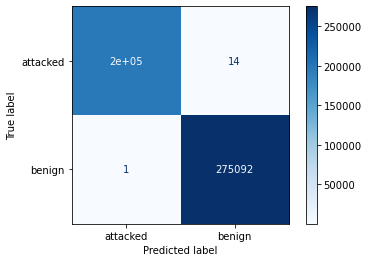

In [489]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)
plot = plot_confusion_matrix(model_rf, X_valid, y_valid, display_labels=labels, cmap=plt.cm.Blues)

In [634]:
X_train

,SourcePort,DestinationPort,Source,Destination,Time
1847261,55985,8043,27149,27275,364.679536
172098,5914,52330,27132,27275,48.899090
1065083,64774,9988,27149,27275,53.152882
805621,64782,9988,27132,27275,34.970878
134683,19604,6567,27149,17718,783686.311129
...,...,...,...,...,...
1742140,55986,8043,27132,27275,324.173832
1421061,60111,8899,27132,27275,77.308052
958891,64782,9988,27149,27275,44.773561
1410803,60204,8899,27149,27275,76.112713


In [506]:
hist_lit = []
for i in [1,3,5,10,20]:
    model = keras.models.Sequential([
        keras.layers.Dense(i, activation="relu", input_shape=[X_train.shape[1]]),
        keras.layers.Dense(1, activation="sigmoid")
    ])

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    history = model.fit(X_train, y_train, epochs=10, validation_data = (X_valid, y_valid))
    hist_list.append(history)

Train on 1417934 samples, validate on 472645 samples
Epoch 1/10
1417934/1417934 [==============================] - 135s 95us/sample - loss: 90.3166 - accuracy: 0.5798 - val_loss: 0.6796 - val_accuracy: 0.5820
Epoch 2/10
1417934/1417934 [==============================] - 103s 73us/sample - loss: 0.6797 - accuracy: 0.5818 - val_loss: 0.6797 - val_accuracy: 0.5820
Epoch 3/10
1417934/1417934 [==============================] - 135s 95us/sample - loss: 0.6797 - accuracy: 0.5818 - val_loss: 0.6796 - val_accuracy: 0.5820
Epoch 4/10
1417934/1417934 [==============================] - 137s 97us/sample - loss: 0.6797 - accuracy: 0.5818 - val_loss: 0.6797 - val_accuracy: 0.5820
Epoch 5/10
1417934/1417934 [==============================] - 138s 97us/sample - loss: 0.6797 - accuracy: 0.5818 - val_loss: 0.6796 - val_accuracy: 0.5820
Epoch 6/10
1417934/1417934 [==============================] - 140s 99us/sample - loss: 0.6797 - accuracy: 0.5818 - val_loss: 0.6796 - val_accuracy: 0.5820
Epoch 7/10
14179

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv1D(i, activation="relu", input_shape=[X_train.shape[1]]),
    keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data = (X_valid, y_valid))

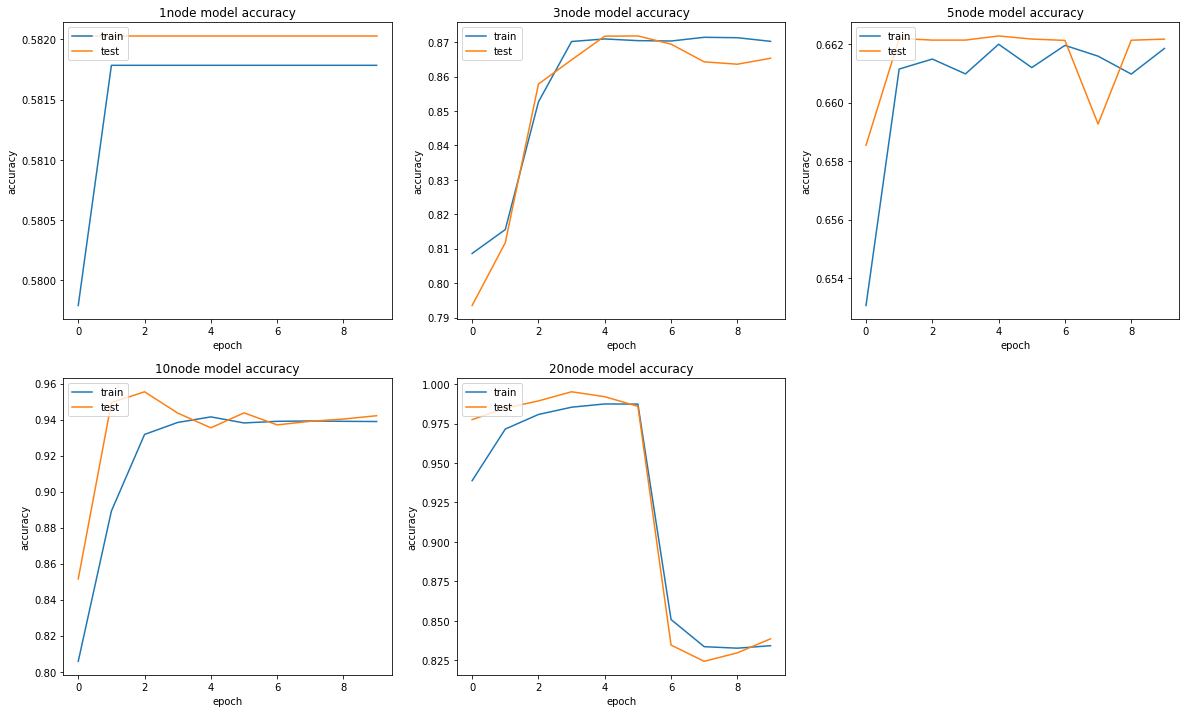

In [593]:
node_list = [1,3,5,10,20]
plt.figure(figsize=(20, 12))
for i in range(1,6):
    plt.subplot(2,3,i)    
###### 초기에 hist_list를 하나 추가해줘서 현재i임 다시 실행시 i-1로 바꿀것
    plt.plot(hist_list[i].history['accuracy'])
    plt.plot(hist_list[i].history['val_accuracy'])
    plt.title(str(node_list[i-1])+ 'node model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [632]:
hist_list[5].history["val_accuracy"]

[0.9774757,
 0.9847412,
 0.9893239,
 0.995119,
 0.9919961,
 0.9858964,
 0.8346095,
 0.8243248,
 0.82970726,
 0.8385744]

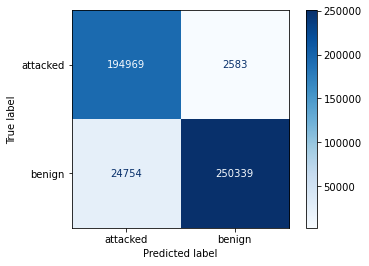

In [626]:
pred = hist_list[4].model.predict_classes(X_valid)
cm = confusion_matrix(y_valid, pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

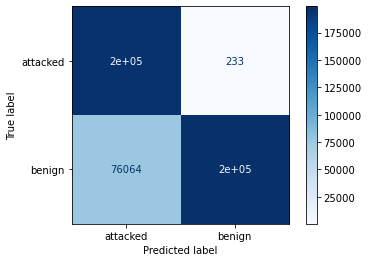

In [633]:
pred = hist_list[5].model.predict_classes(X_valid)
cm = confusion_matrix(y_valid, pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)